In [ ]:
%matplotlib inline

# Assignment 4

**DUE: Sunday February 28, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = "Kenny Bun"
STUDENT_ID = "1743837"

1 - Gesture Recognition using Convolutional Neural Networks
---
American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabet are shown below. In this question, you will focus on classifying these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters, we want to detect which letter is being represented.


<img src = 'https://drive.google.com/uc?id=1nRxq6yqDkmumUuePXfDx_5YgGl9vKXcj' width="300">






Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1jDDjJzhZ7XV5DMRAEg23ymrz-IjnpGIO'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data.zip')

zip_ref = zipfile.ZipFile("data.zip", 'r')
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
zip_ref.close()

In [ ]:
# Personally use to delete the validation files so that I can rerun everything 
# including create val_files
!rm -rf asl_alphabet_train/asl_aphabet_val/

Understanding and Processing the Data

Now that you downloaded the data, you see two folders containing training and test data. Complete the following steps:

1) read in the training and test data. Examine the data folders carefully to see how file names and folder names represent different labels (29 labels in total) in the datasets.

2) rescale the pixel values of the training and test images from [0,255] to [0,1].

3) make sure that all of your imges are of size $200\times 200$. If not, scale them appropriately.

4) Ensure that your target values (classes) are stored appropriately. You must have 29 classes for 'a-z', 'del', 'nothing', and 'space'.

In [ ]:
import shutil
import os
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from matplotlib import image

files = os.listdir()
print(files)

test_dir = os.path.join('./', 'asl_alphabet_test', 'asl_alphabet_test')
tfiles = os.listdir(test_dir)

train_dir = './asl_alphabet_train/asl_alphabet_train/'
train_files = os.path.join('./', 'asl_alphabet_train', 'asl_alphabet_train')
trfiles = os.listdir(train_files)  

os.path.join

train_root = './asl_alphabet_train/asl_alphabet_train/'
test_root= './asl_alphabet_test/asl_alphabet_test/'
val_root = './asl_alphabet_train/asl_aphabet_val/'

folders = os.listdir(train_root)
os.mkdir(val_root)
for d in folders:
  os.mkdir(val_root + d)

for i, label in enumerate(folders):
  all_files = os.listdir(train_root + label)
  np.random.shuffle(all_files)
  if i == 0:
    num_train = np.int(.8 * len(all_files))
    num_val = num_test = np.int(.2 * len(all_files))
  train = all_files[:num_train]
  val = all_files[num_train:]

  for img in val:
    shutil.move(train_root + label + '/' + img, val_root + label + '/')

label_map = dict(zip(string.ascii_lowercase, range(0,26)))
label_map['del'] = 26
label_map['nothing'] = 27
label_map['space'] = 28

['.config', 'asl_alphabet_train', 'asl_alphabet_test', 'data.zip', 'adc.json', 'sample_data']


In [ ]:
def load_test_asl_data(directory):
  X, y = [], []
  count = 0
  for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      img_dir = os.path.join(direcotry, filename)
      class_index = filename.partition('_')[0]
      asl_img = image.imread(img_dir)
      yencode = np.zeros(29)
      yencode[label_map[class_index]] = 1
      X.append(asl_img)
      y.append(yencode)
      count += 1
  return np.array(X), np.array(y)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

with tf.device('/device:GPU:0'): # Doesn't change the runtime too much 

  #model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

  train_datagen = ImageDataGenerator(rescale = 1./255)
  val_datagen = ImageDataGenerator(rescale = 1./255)

  train_generator = train_datagen.flow_from_directory(
      train_root, 
      target_size = (200,200),
      batch_size = 30,
      class_mode = 'categorical')
  
  validation_generator = val_datagen.flow_from_directory(
      val_root, 
      target_size = (200,200),
      batch_size = 30,
      class_mode = 'categorical')

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
# plt.imshow(train)
# plt.colorbar()
# plt.show()

### Part B) Building a Convolutional Neural Network
For this assignment, we are not going to give you any starter code. You will be writing a convolutional neural network from scratch. You are welcome to use any code from previous class exercises, section handouts, and lectures. You should also write your own code.

You may use the TensorFlow documentation freely. You might also find online tutorials helpful. However, all code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unnecessary for loops). Ensure enough comments are included in the code so that your TA can understand what you are doing. It is your responsibility to show that you understand what you write.

Follow the steps below to show your work.

#### Step 1) Building the Network
Build a convolutional neural network model that takes the ($200\times 200$ RGB) image as input, and predicts the letter. Explain your choice of the architecture: how many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional? What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
### YOUR CODE HERE ###
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

# Building the architecture of the deep neural network
model = Sequential()

model.add(Conv2D(filters = 16,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32,      
                 kernel_size = (5, 5), 
                 padding = 'Same',
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))  

model.add(Dense(29, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

[I initially chose 10 units and 20 units for shorter runtime, then 16 and 32 for more features in hope of getting a better model. I had 2 layers (I think 3 layers is also good, but I already achieved 99% in accurary and low loss, so I'm happy with 2 layers), and both layers are convolutional. I had 2x2 max pooling to downsample the image for the sake of faster runtime with smaller parameters. I used 'ReLu' activation function.]

#### Step 2) Training the Network
Write code that trains your neural network given the training data. Your training code should make it easy to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function and optimizer.

Plot the training curve as well.

In [ ]:
### YOUR CODE HERE ###
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

history = model.fit(
  train_generator,
  steps_per_epoch = 80,
  epochs = 110,
  validation_data = validation_generator,
  validation_steps = len(validation_generator)//80,
  verbose = 1,
  shuffle=True)
  

Epoch 1/110
80/80 [==============================] - 37s 57ms/step - loss: 3.3612 - acc: 0.0657 - val_loss: 3.2704 - val_acc: 0.1190
Epoch 2/110
80/80 [==============================] - 4s 54ms/step - loss: 2.9585 - acc: 0.1463 - val_loss: 3.1204 - val_acc: 0.1619
Epoch 3/110
80/80 [==============================] - 4s 54ms/step - loss: 2.5313 - acc: 0.2525 - val_loss: 2.8851 - val_acc: 0.2238
Epoch 4/110
80/80 [==============================] - 4s 54ms/step - loss: 2.3801 - acc: 0.2846 - val_loss: 2.5891 - val_acc: 0.2857
Epoch 5/110
80/80 [==============================] - 4s 53ms/step - loss: 2.1370 - acc: 0.3416 - val_loss: 2.3436 - val_acc: 0.2810
Epoch 6/110
80/80 [==============================] - 4s 52ms/step - loss: 2.0834 - acc: 0.3390 - val_loss: 2.2653 - val_acc: 0.3095
Epoch 7/110
80/80 [==============================] - 4s 52ms/step - loss: 1.8626 - acc: 0.3956 - val_loss: 1.9281 - val_acc: 0.3619
Epoch 8/110
80/80 [==============================] - 4s 52ms/step - loss: 1

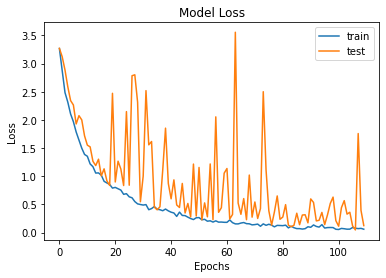

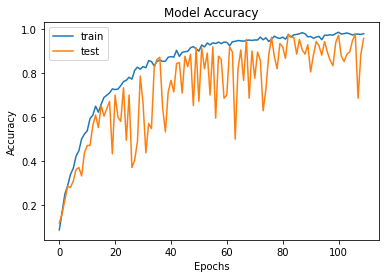

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

[As we have multi-classes classification of images, Categorical_crossentropy, also called Softmax Loss, seems to be a good fit the loss funciton. With 100-120 Epochs, the accuracy should be high enough for an acceptable/good model. For the optimizer, I tested both SGD and Adam, it appeared to me the SGD is a bit better than Adam. However, both model accuracy and loss are in the good acceptable state where accuracy is between 97-98% with SGD optimizer accuracy average about 1% higher.]

#### Step 3) Overfit to A Small Dataset

One way to sanity check our neural network model and training code is to check whether the model is capable of overfitting or memorizing a small dataset. A properly constructed CNN with correct training code should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. sample from the training data). Then show that your model and training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and a learning rate that is not too high, you should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

In [ ]:
### YOUR CODE HERE ###
X_set, y_set = next(train_generator)
model.compile(loss = 'categorical_crossentropy', 
              optimizer= 'adam', metrics = ['acc'])

history = model.fit(
  X_set,
  y_set,
  steps_per_epoch = 3,
  epochs = 20,
  validation_data = validation_generator,
  validation_steps = 20,
  verbose = 2)

Epoch 1/20
3/3 - 2s - loss: 4.7403 - acc: 0.5667 - val_loss: 10.8926 - val_acc: 0.2817
Epoch 2/20
3/3 - 1s - loss: 6.2953 - acc: 0.5333 - val_loss: 12.6357 - val_acc: 0.2417
Epoch 3/20
3/3 - 1s - loss: 0.9388 - acc: 0.7333 - val_loss: 10.3381 - val_acc: 0.3200
Epoch 4/20
3/3 - 1s - loss: 0.0829 - acc: 0.9333 - val_loss: 12.0861 - val_acc: 0.2783
Epoch 5/20
3/3 - 1s - loss: 0.3246 - acc: 0.9667 - val_loss: 14.1769 - val_acc: 0.2500
Epoch 6/20
3/3 - 1s - loss: 0.1087 - acc: 0.9333 - val_loss: 17.9213 - val_acc: 0.2017
Epoch 7/20
3/3 - 1s - loss: 1.2566e-04 - acc: 1.0000 - val_loss: 19.6490 - val_acc: 0.1833
Epoch 8/20
3/3 - 1s - loss: 0.0677 - acc: 0.9667 - val_loss: 22.0825 - val_acc: 0.1467
Epoch 9/20
3/3 - 1s - loss: 5.5130e-05 - acc: 1.0000 - val_loss: 21.3880 - val_acc: 0.1917
Epoch 10/20
3/3 - 1s - loss: 3.8268e-05 - acc: 1.0000 - val_loss: 21.1407 - val_acc: 0.1683
Epoch 11/20
3/3 - 1s - loss: 0.0308 - acc: 0.9667 - val_loss: 20.8702 - val_acc: 0.1817
Epoch 12/20
3/3 - 1s - loss: 

#### Step 4) Hyperparameter Search

1. List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to the model architecture.

2. Tune the hyperparameters you listed previously, trying as many values as you need to until you feel satisfied that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

3. Choose the best model out of all the ones that you have trained. Justify your choice.

4. Report the test accuracy of your best model. You should only do this step once.







In [ ]:
### YOUR CODE HERE ###
hyperparam =  Sequential()

hyperparam.add(Conv2D(filters = 32,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))

hyperparam.add(MaxPooling2D(pool_size = (2, 2)))
hyperparam.add(BatchNormalization())
hyperparam.add(Conv2D(filters = 64,      
                 kernel_size = (5, 5), 
                 padding = 'Same',
                 activation = 'relu'))

hyperparam.add(MaxPooling2D(pool_size = (2, 2)))

hyperparam.add(Flatten())

hyperparam.add(Dense(128, activation = 'relu'))  
hyperparam.add(Dense(64, activation = 'relu'))  
hyperparam.add(Dense(29, activation = "softmax"))

hyperparam.summary()

hyperparam.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

history = hyperparam.fit(
  train_generator,
  steps_per_epoch = 80,
  epochs = 100,
  validation_data = validation_generator,
  validation_steps = len(validation_generator)//80,
  verbose = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

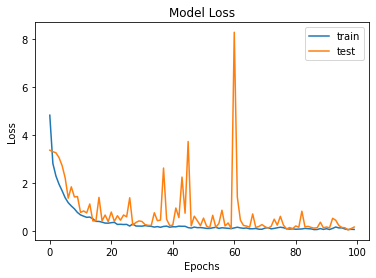

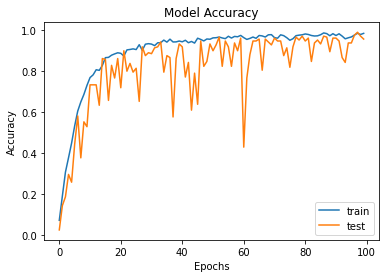

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

[The three hyperparameters that are worth tuing are max pooling, dense, and filters in Conv2D. These hyperparameter helps determine the runtime of the model, the high accuracy, and low loss. After many attempt in tuning the hyperparameters, I found that the first choice of model seems the best in terms of faster runtime, and the accuracy and loss average about the same with the first model is slightly better. They both achieved 98-99% accuracy, but slightly higher loss than the first model.]

## Question 2 - Transfer Learning
---
For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a similar task to the one you need to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed Transfer Learning. In this assignment, we will use Transfer Learning to extract features from the hand gesture images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which get utilized by the fully connected layers for correct classification.


Keras even has pretrained models built in for this purpose. 

#### Keras Pretrained Models
        Xception
        VGG16
        VGG19
        ResNet, ResNetV2, ResNeXt
        InceptionV3
        InceptionResNetV2
        MobileNet
        MobileNetV2
        DenseNet
        NASNet

Usually one uses the layers of the pretrained model up to some point, and then creates some fully connected layers to learn the desired recognition task. The earlier layers are "frozen", and only the later layers need to be trained. We'll use VGG16, which was trained to recognize 1000 objects in ImageNet. What we're doing here for our classifier may be akin to killing a fly with a shotgun, but the same process can be used to recognize objects the original network couldn't (i.e., you could use this technique to train your computer to recognize family and friends).

In [ ]:
# Some stuff we'll need...
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

Creating this pretrained network is a one line command. Notice we specified that the "top" should not be included. We aren't classifying 1000 different categories like ImageNet, so we don't include that layer. We'll add our own layer more suited to the task at hand.

We choose 224 as our image dimension because the pretrained VGG16 was trained using the ImageNet dataset which has images of this dimension.

In [ ]:
# Import the VGG16 trained neural network model, minus it's last (top) neuron layer.
base_model = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (200, 200, 3), 
                   pooling = None)

58892288/58889256 [==============================] - 0s 0us/step


Let's take a look at this pretrained model:

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Please do realize, this may be overkill for our toy recognition task. One could use this network with some layers (as we're about to add) to recognize 100 dog breeds or to recognize all your friends. If you wanted to recognize 100 dog breeds, you would use a final 100 neuron softmax for the final layer. We'll need a final softmax layer as before. First let's freeze all these pretrained weights. They are fine as they are.

In [ ]:
# This freezes the weights of our VGG16 pretrained model.
for layer in base_model.layers:  
    layer.trainable = False

### Part A) Building the Classifier
Now let's just add a flatten layer, a trainable dense layer, and a final softmax layer to the network to complete the classifier model for our gesture recognition task. Use Keras' functional approach to building a network.

In [ ]:
# Now add layers to our pre-trained base model and add classification layers on top of it
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(len(label_map), activation = 'softmax')(x) 

# And now put this all together to create our new model.
model = Model(inputs = base_model.input, outputs = x) 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

### Part B) Initializing Training Parameters

Compile the model using an appropriate loss function and optimizer.

In [ ]:
# Compile the model.
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

### Part C) Training the Model

Train your new network, including any hyperparameter tuning. Plot the training curve of your best model only.

As you can see here in the Keras docs:

https://keras.io/api/applications/vgg/#vgg16-function

that we are required to preprocess our image data in a specific way to use this pretrained model, so let's go ahead and do that first.

In [ ]:
# Preprocess your input image data

### YOUR CODE HERE ###
# X = preprocess_input(X_train)
# y = to_categorical(y, 10)

In [ ]:
# Train the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

history = model.fit(
  train_generator,
  steps_per_epoch = 80,
  epochs = 100,
  validation_data = validation_generator,
  validation_steps = 20,
  verbose = 2)

Epoch 1/100
80/80 - 17s - loss: 2.9355 - acc: 0.2025 - val_loss: 2.2796 - val_acc: 0.3967
Epoch 2/100
80/80 - 11s - loss: 1.8726 - acc: 0.5221 - val_loss: 1.4640 - val_acc: 0.6433
Epoch 3/100
80/80 - 11s - loss: 1.3326 - acc: 0.6621 - val_loss: 1.0606 - val_acc: 0.7350
Epoch 4/100
80/80 - 11s - loss: 0.9934 - acc: 0.7550 - val_loss: 0.7736 - val_acc: 0.8200
Epoch 5/100
80/80 - 11s - loss: 0.7238 - acc: 0.8338 - val_loss: 0.7279 - val_acc: 0.8233
Epoch 6/100
80/80 - 11s - loss: 0.6053 - acc: 0.8621 - val_loss: 0.5969 - val_acc: 0.8583
Epoch 7/100
80/80 - 11s - loss: 0.5174 - acc: 0.8675 - val_loss: 0.4501 - val_acc: 0.8900
Epoch 8/100
80/80 - 11s - loss: 0.4486 - acc: 0.8992 - val_loss: 0.4011 - val_acc: 0.9300
Epoch 9/100
80/80 - 11s - loss: 0.3899 - acc: 0.9083 - val_loss: 0.4254 - val_acc: 0.8900
Epoch 10/100
80/80 - 11s - loss: 0.3603 - acc: 0.9225 - val_loss: 0.3808 - val_acc: 0.8983
Epoch 11/100
80/80 - 11s - loss: 0.3116 - acc: 0.9362 - val_loss: 0.3140 - val_acc: 0.9183
Epoch 12

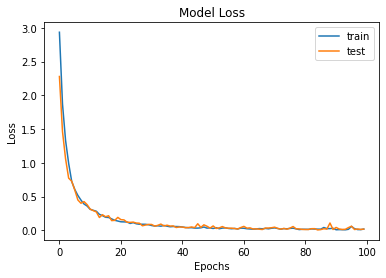

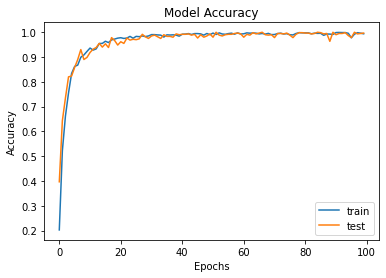

In [ ]:
# Plot the training curve

### YOUR CODE HERE ###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()


### Part D) Your Best Classifier

Add on your own last layers to the pretrained model and train it on the training data (in the previous parts you could have only one flatten layer and one dense layer to do the classification). You can increase (or decrease) the number of nodes per layer, increase (or decrease) the number of layers, and add dropout if your model is overfitting, change the hyperparameters, change your optimizer, etc. Try to get the validation accuracy higher than what the previous transfer learning model was able to obtain, and try to minimize the amount of overfitting.

Plot the classification accuracy for each epoch. Report the best test accuracy your model was able to achieve.

In [ ]:
### YOUR CODE HERE ###
hyperparam =  Sequential()

hyperparam.add(Conv2D(filters = 32,      
                 kernel_size = (3, 3), 
                 padding = 'Same',
                 activation = 'relu', 
                 input_shape = (200, 200, 3)))

hyperparam.add(MaxPooling2D(pool_size = (2, 2)))
hyperparam.add(BatchNormalization())
hyperparam.add(Conv2D(filters = 64,      
                 kernel_size = (5, 5), 
                 padding = 'Same',
                 activation = 'relu'))

hyperparam.add(MaxPooling2D(pool_size = (2, 2)))

hyperparam.add(Flatten())

hyperparam.add(Dense(128, activation = 'relu'))  

hyperparam.add(Dense(29, activation = "softmax"))

hyperparam.summary()

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
hyperparam.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

history = hyperparam.fit(
  train_generator,
  steps_per_epoch = 80,
  epochs = 100,
  validation_data = validation_generator,
  validation_steps = 20)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

[I tried to increase the validation accuracy by adding two convolutional layers just like Q1, I increased the number of filters to has more parameters to learn so that it can improve the validation accuracy.]